<h1> ______________________________________ </h1>

<h1> Time and Energy resolution calculation </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we calculate the energy and time resolution of our photosensor (SiPM Hamamatsu in this case) the following way:</p>

- <p style="font-size: 17px; color: black; font-weight: bold;"> Time resolution: </p> 
<p style="font-size: 17px; color: black;"> We set a voltage threshold and we measure the time difference between when our signal and our trigger waveform pass that threshold. The std of that time difference distribution will be our time resolution. The time resolution is not the same for all signals so we differentiate among signals of 1pe, 2pe, 3pe, etc. </p> 


- <p style="font-size: 17px; color: black; font-weight: bold;"> Energy resolution: </p> 
<p style="font-size: 17px; color: black;"> We save for each waveform the value of the peak, then we do the distribution of that value for each waveform type, ie we do different distributions separating waveforms corresponding to 1pe, 2pe, 3pe, etc. The std of that peak distribution will be our energy resolution. </p> 


<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> In this notebook we don't save all the waveforms, but rather work with them re-reading the files. This might take more time but less memory, preventing the laptop to collapse. </p>
-  <p style="font-size: 17px; color: black;"> Unified Y11 and B2 notebook. </p>
-  <p style="font-size: 17px; color: black;"> 10K events each fibers. </p>
-  <p style="font-size: 17px; color: black;"> Let's try and work with ALL events. </p>
-  <p style="font-size: 17px; color: black;"> The photosensor signal saturates (there are values considered inf). </p>
-  <p style="font-size: 17px; color: black;"> Waveforms include just 1 peak. </p>
-  <p style="font-size: 17px; color: black;"> Signal happens AFTER THE TRIGGER. </p>


-  <p style="font-size: 17px; color: black;"> Use interpolation to get the EXACT time at which the waveform cuts the threshold. This way we can basically work with a function intead of the data. </p>


-  <p style="font-size: 17px; color: black;"> Calculate chi2 manually cause to use the built in function, the fit has to be normalized and we don't understand why. </p>
-  <p style="font-size: 17px; color: black;"> Variable bining in the distributions as sqrt(Nevents). </p>


-  <p style="font-size: 17px; color: black;"> Instead of obtaining the Npe peaks ad hoc we do it finding the peaks in the maximums distribution. </p>
-  <p style="font-size: 17px; color: black;"> Same way use this distribution to determine dV from each peak to get rid of the in between events. </p>


-  <p style="font-size: 17px; color: black;"> We can choose between a variable or a fixed threshold with fix_th = True/False. </p>


-  <p style="font-size: 17px; color: black;"> Energy distribution in % instead of absolute values. </p>
-  <p style="font-size: 17px; color: black;"> Fit the sigma vs $ N_{pe} $ plot to the corresponding cuadratic sum of terms. </p>



In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [72]:
import math

In [73]:
import scipy
from scipy import stats, integrate
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import root, root_scalar

In [74]:
import os

<h1> _________________________________________________________________________________________________________ </h1>


<h1> __________________________ </h1>
<h2> Functions </h2>

-  <p style="font-size: 17px; color: black;"> <b> gauss(x, a,  mu, sigma): </b> Gaussian normalized to $a$. </p>


-  <p style="font-size: 17px; color: black;"> <b> f_cut(x, f, val): </b> To find the cut of a $f(x)$ function with a certain value $val$ we first use <b> f_cut </b> to move $f(x) \rightarrow f(x) - val$ and then find it's roots, ie, $f(x) - val = 0$. </p>


-  <p style="font-size: 17px; color: black;"> <b> resolution_eq(E, a, b, c): </b> Resolution equation to which our results should fit. </p>



In [75]:
# Gaussian
# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
# def gauss(x,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian 
#     return (x.sum()/gaussian.sum())*gaussian 

# Function offsetting
# To find the cut of a function with a certain value first we offset the function then find the roots
def f_cut(x, f, val):
    return f(x) - val

# Resolution equation
def resolution_eq(E, a, b, c):
    
    res = np.sqrt( (a/np.sqrt(E))**2 + (b/E)**2 + c**2)
    
    return res


-  <p style="font-size: 17px; color: black;"> <b> wave_prep(file): </b> Take a waveform and prepare it to work with it by separating the different variables, correcting offset and possible signal saturation. </p>



In [76]:
def wave_prep(file_name, fiber, waveform_saturation = np.inf):
    
    input_file = os.path.join(path[fiber], file_name)
    
    # Read the CSV file using pandas
    df = pd.read_csv(input_file, header=14)
    
    time = np.array(df['TIME']*1e6) # [us]
    signal = np.array(df['CH1']*1e3) # [mV]
    LED = np.array(df['CH2']*1e3) # [mV]

    # Offsets
    offset_LED = LED[LED < 0].mean(); LED = LED - offset_LED

    offset_signal = signal[signal < 0].mean(); signal = signal - offset_signal
    
    
    # Saturation
    signal = np.where(signal < waveform_saturation, 
                      signal,
                      signal[signal < waveform_saturation].max())
    
    return time, signal, LED

<h1> __________________________ </h1>
<h2> Data </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [77]:
# filename = []
path = {}

init_path = '/home/investigator/mariandbt/python/data/'

path['y11'] = init_path + '20230508/'
path['b2'] = init_path + '20230525' + '_t_res_b2/'

-  <p style="font-size: 17px; color: black;"> Parameters to read the file. </p>

In [78]:
files = {}

In [79]:
# Get all files in the folder
files['y11'] = os.listdir(path['y11'])
files['b2'] = os.listdir(path['b2'])

-  <p style="font-size: 17px; color: black;"> Parameters of the read file. </p>

In [80]:
n_frames = int(len(files['y11']))
n_points = int(6250)

print('n_points = ', n_points)
print('n_frames = ', n_frames)

n_points =  6250
n_frames =  10000


<h1> __________________________ </h1>
<h2> Global parameters </h2>

-  <p style="font-size: 17px; color: black;"> <b> Analysis parameters </b> </p>

 -  <p style="font-size: 17px; color: black;"> <b> dV: </b> When separating signals to differentiate between different photo-electron signals we define a validity region around the selected $N_{pe}$ value with width $dV$. </p>
 
 -  <p style="font-size: 17px; color: black;"> <b> fix_th: </b> True if we want to use a fixed threshold (determined after the multi-pe peaks). If not, the threshold at which to measure the time difference between signal and trigger is variable depending on each waveform. </p>
 


In [81]:
dV = 30 # [mV] Voltage difference from the multi-pe peaks we're considering

In [82]:
fix_th = False # True if we want to use a fixed threshold (determined after the multi-pe peaks)

<h1> __________________________ </h1>
<h2> Analysis </h2>

<h2> Determination of the $N_{pe}$ peaks </h2>

-  <p style="font-size: 17px; color: black;"> Use a peak distribution and select this distribution peaks as the $N_{pe}$ values and $dV$ as the validity region around these value to consider a certain signal part of that $N_{pe}$ group. </p>

-  <p style="font-size: 17px; color: black;"> Save the maximum of each waveform to do the distribution later. Since there are some waveforms that saturate we pick the second highest valid value. </p>

In [83]:
pe_peaks = {}
pe_peaks['y11'] = []
pe_peaks['b2'] = []

In [ ]:
for fiber in ['y11', 'b2']:
    for ii, file_name in enumerate(files[fiber]):
        
        _, ss, _ = wave_prep(file_name, fiber, waveform_saturation = np.inf)
        pe_peaks[fiber].append(ss.max())
        
    pe_peaks[fiber] = np.array(pe_peaks[fiber])
    print(f'Done with {fiber} fibers!')
    

Done with y11 fibers!


-  <p style="font-size: 17px; color: black;"> Set the parameters to later find the peaks in the distribution and determine the acceptance region around this peak. </p>

In [ ]:
height_min = {} # height threshold to which consider a peak
height_min = {} # height threshold to which consider a peak
dist_min = {} # min distance between peaks required
dif_min = {} # min height difference between the peak point and their neighbours 

In [ ]:
height_min['y11'] = n_frames/250. # height threshold to which consider a peak
height_min['y11'] = 10. # height threshold to which consider a peak
dist_min['y11'] = 5. # min distance between peaks required
dif_min['y11'] = None # min height difference between the peak point and their neighbours 

In [ ]:
height_min['b2'] = n_frames/250. # height threshold to which consider a peak
height_min['b2'] = 10. # height threshold to which consider a peak
dist_min['b2'] = 5. # min distance between peaks required
dif_min['b2'] = None # min height difference between the peak point and their neighbours 

- <p style="font-size: 17px; color: black;"> Waveform's maximums distribution and location of the photo-electrons peaks and the acceptance region around.

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,7), constrained_layout=True)

x_ax = {}
peaks = {}

for i, key in enumerate(['y11', 'b2']):

    events, bins, bars = ax[i].hist(pe_peaks[key], 100, 
                                 density=False, 
                                 label='Multi-photo-electron spectrum', 
                                 histtype='step')
    x_ax[key] = bins[:-1]
    diffs = np.abs(np.diff(bins))
    # accept_region = np.array(dV/diffs, dtype = int) # instead of defining the acceptance region by Voltage we define it in terms of bins
    accept_region = dV*np.ones(len(x_ax[key]))

    peaks[key], _ = find_peaks(events, height=height_min[key], threshold=dif_min[key], distance=dist_min[key])

    for ii in range(len(peaks[key])):
        ax[i].fill_between([(x_ax[key][peaks[key]] - accept_region[peaks[key]])[ii], 
                         (x_ax[key][peaks[key]] + accept_region[peaks[key]])[ii]], 
                        events[peaks[key]].max(), 
                        color = 'magenta', alpha = 0.3, label = r'Peak regions ($\pm$ %.2f mV)'%(dV)) 

    ax[i].plot(x_ax[key][peaks[key]], events[peaks[key]], 'o', label = 'Identified peaks')
    ax[i].plot(x_ax[key], height_min[key]*np.ones(len(x_ax[key])), label = 'Minimum height considered for a peak')

    ax[i].set_xlabel('Pe signal [mV]')
    ax[i].set_ylabel('Counts')
    ax[i].set_title(key)

    hand, labl = ax[i].get_legend_handles_labels()
    hand, labl = np.array(hand), np.array(labl)
    not_duplicated = ~pd.DataFrame(labl).duplicated()

    ax[i].legend(hand[not_duplicated], labl[not_duplicated], loc = 'best')
    # ax[i].legend(loc='best')

In [ ]:
signal_pe = {}
n_pe = {}

In [ ]:
for key in ['y11', 'b2']:
    signal_pe[key] = x_ax[key][peaks[key]]
    signal_pe[key] = signal_pe[key][signal_pe[key] > 50] # to make sure not to include the 0 pe
    n_pe[key] = len(signal_pe[key])
    
    print(r'Npe for %s fibers = '%(key), n_pe[key])
print('Npe values = ', signal_pe)

In [23]:
import matplotlib as mpl
import copy

my_cmap = copy.copy(plt.get_cmap('plasma')) # copy the default cmap
my_cmap.set_bad(my_cmap.colors[0]) #  set the color of invalid or masked values in the colormap

t_peak = {}
t_peak['y11'] = 0.53
t_peak['b2'] = 0.083


In [24]:
time = {}
signal = {}
LED = {}

top = 1000

for fiber in ['y11', 'b2']:
    
    t = []
    s = []
    l = []
    
    for file_name in files[fiber][:top]:
        
        tt, ss, ll = wave_prep(file_name, fiber, waveform_saturation = np.inf)
        
        t.append(tt)
        s.append(ss)
        l.append(ll)
    
    time[fiber] = np.concatenate(t)    
    signal[fiber] = np.concatenate(s)    
    LED[fiber] = np.concatenate(l)

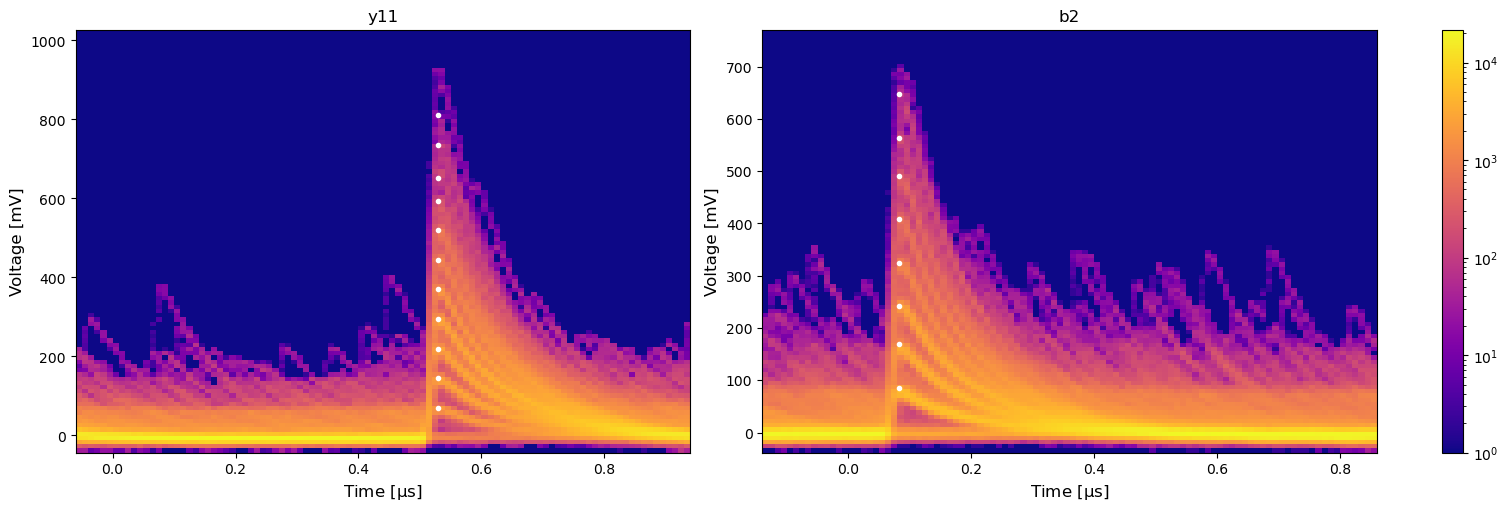

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), constrained_layout=True)

for i, key in enumerate(['y11', 'b2']):

    counts, xedges, yedges, im = ax[i].hist2d(time[key], signal[key], 
                                           bins=100, rasterized=True, 
                                           range=((time[key].min(),time[key].max()), 
                                                  (signal[key].min(), 1.1*signal[key].max())), 
                                           cmap=my_cmap, norm=mpl.colors.LogNorm(vmin = 1))

    for ii in range(n_pe[key]):
        ax[i].plot(t_peak[key], signal_pe[key][ii], 'ow', markersize = 3, label = '%s pe'%(ii))



    ax[i].set_xlabel(r"Time [$\mathrm{\mu}$s]", size='larger')
    ax[i].set_ylabel("Voltage [mV]", size='larger')
    ax[i].set_title(key)
    
    # ax[i].legend(loc = 'best')

fig.colorbar(im, ax = ax, orientation='vertical')
# fig.savefig("waveforms.pdf")

- <p style="font-size: 17px; color: black;"> Set fixed threshold to 50% of the single photo-electron.

In [26]:
th_fixed = .5*signal_pe['y11'][0] # [mV] Height at which we measure the time difference between LED and Signal

<h2> Waveform </h2>

-  <p style="font-size: 17px; color: black;"> Interpolate the waveform to create a function. </p>

In [27]:
frame = 413

In [28]:
tt = {}
ss = {}
ll = {}

In [29]:
for fiber in ['y11', 'b2']:
    
    file_name = files[fiber][frame]

    tt[fiber], ss[fiber], ll[fiber] = wave_prep(file_name, fiber, waveform_saturation = np.inf)

-  <p style="font-size: 17px; color: black;"> Time region where to look for signal. </p>

In [30]:
tt_min = {}
tt_max = {}
tt_region_mask = {}

In [31]:
tt_min['y11'] = 0.45 # [us]
tt_max['y11'] = 0.7 # [us]

tt_min['b2'] = 0. # [us]
tt_max['b2'] = 0.4 # [us]

In [32]:
for key in ['y11', 'b2']:
    tt_region_mask[key] = (tt[key] > tt_min[key]) & (tt[key] < tt_max[key]) # Where to look for the signal
    

- <p style="font-size: 17px; color: black;"> Threshold to consider a peak in this waveform.

In [33]:
th = {}

In [34]:
for key in ['y11', 'b2']:

    th[key] = max(0.8*signal_pe[key][0], min(0.8*ss[key][tt_region_mask[key]].max(), 0.8*ll[key].max()))

    if fix_th:
        th[key] = th_fixed

    print('threshold for %s fibers = %.2f mV'%(key, th[key]))

threshold for y11 fibers = 255.85 mV
threshold for b2 fibers = 68.38 mV


<p style="font-size: 17px; color: black;"> Data waveform

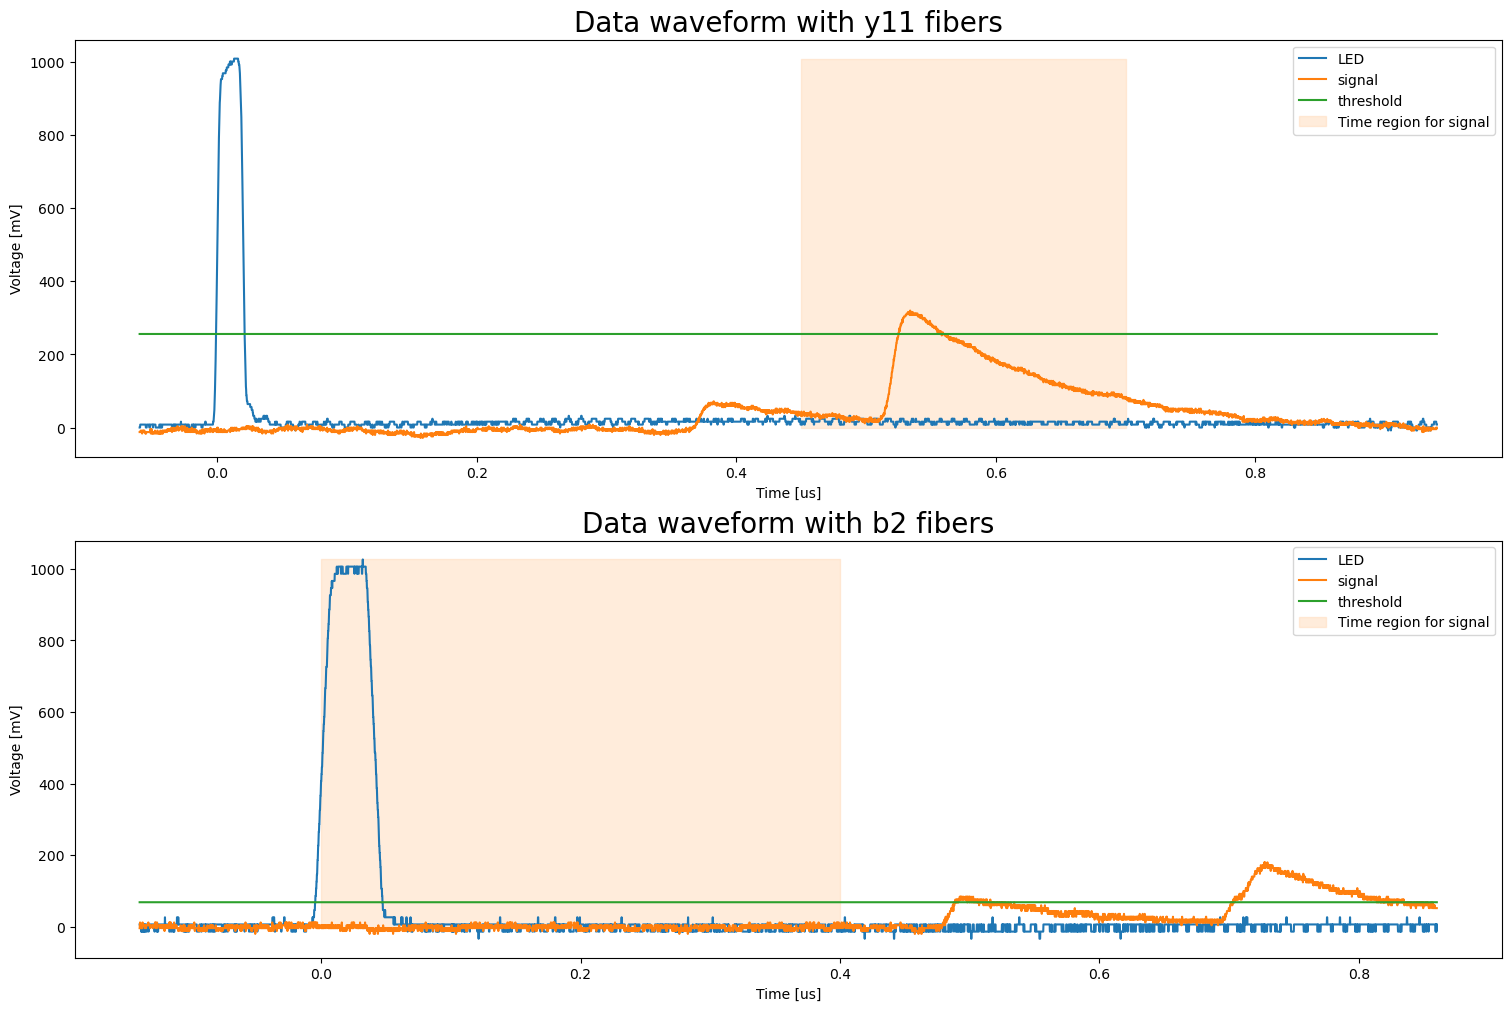

In [35]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10), constrained_layout=True)

for i, key in enumerate(['y11', 'b2']):

    ax[i].plot(tt[key], ll[key], label = 'LED')
    ax[i].plot(tt[key], ss[key], label = 'signal')
    ax[i].plot(tt[key], th[key]*np.ones(len(tt[key])), label = 'threshold')

    ax[i].fill_between([tt_min[key], tt_max[key]], max(ll[key].max(), ss[key].max()), 
                    color = 'peachpuff', alpha = 0.5, label = r'Time region for signal') 

    ax[i].set_ylabel('Voltage [mV]');
    ax[i].set_xlabel('Time [us]');
    ax[i].set_title('Data waveform with %s fibers'%(key), size = 20);
    ax[i].legend(loc = 'best')

- <p style="font-size: 17px; color: black;"> Waveform interpolation and finding the cut with the threshold.

In [36]:
f_ss = {}
f_ll = {}

root_ss = {}
root_ll = {}

dt = {}

In [37]:
for key in ['y11', 'b2']:
    
    # Define the interpolation functions
    f_ss[key] = interp1d(tt[key], ss[key])
    f_ll[key] = interp1d(tt[key], ll[key])

    # Define the intervals where to search for roots
    t0 = tt[key][ss[key] - th[key] < 0.][0]
    tf_ss = tt[key][(tt[key] > tt_min[key]) & (ss[key] - th[key] > 0.)][0]
    tf_ll = tt[key][ll[key] - th[key] > 0.][0]

    # Find the roots of the new function for val = th
    root_ss[key] = root_scalar(f_cut, args=(f_ss[key], th[key],), bracket=[t0, tf_ss]).root
    root_ll[key] = root_scalar(f_cut, args=(f_ll[key], th[key],), bracket=[tt[key].min(), tf_ll]).root

    dt[key] = np.fabs(root_ss[key] - root_ll[key])
    print('dt[%s] = %.2f us'%(key, dt[key]))


dt[y11] = 0.53 us
dt[b2] = 0.49 us


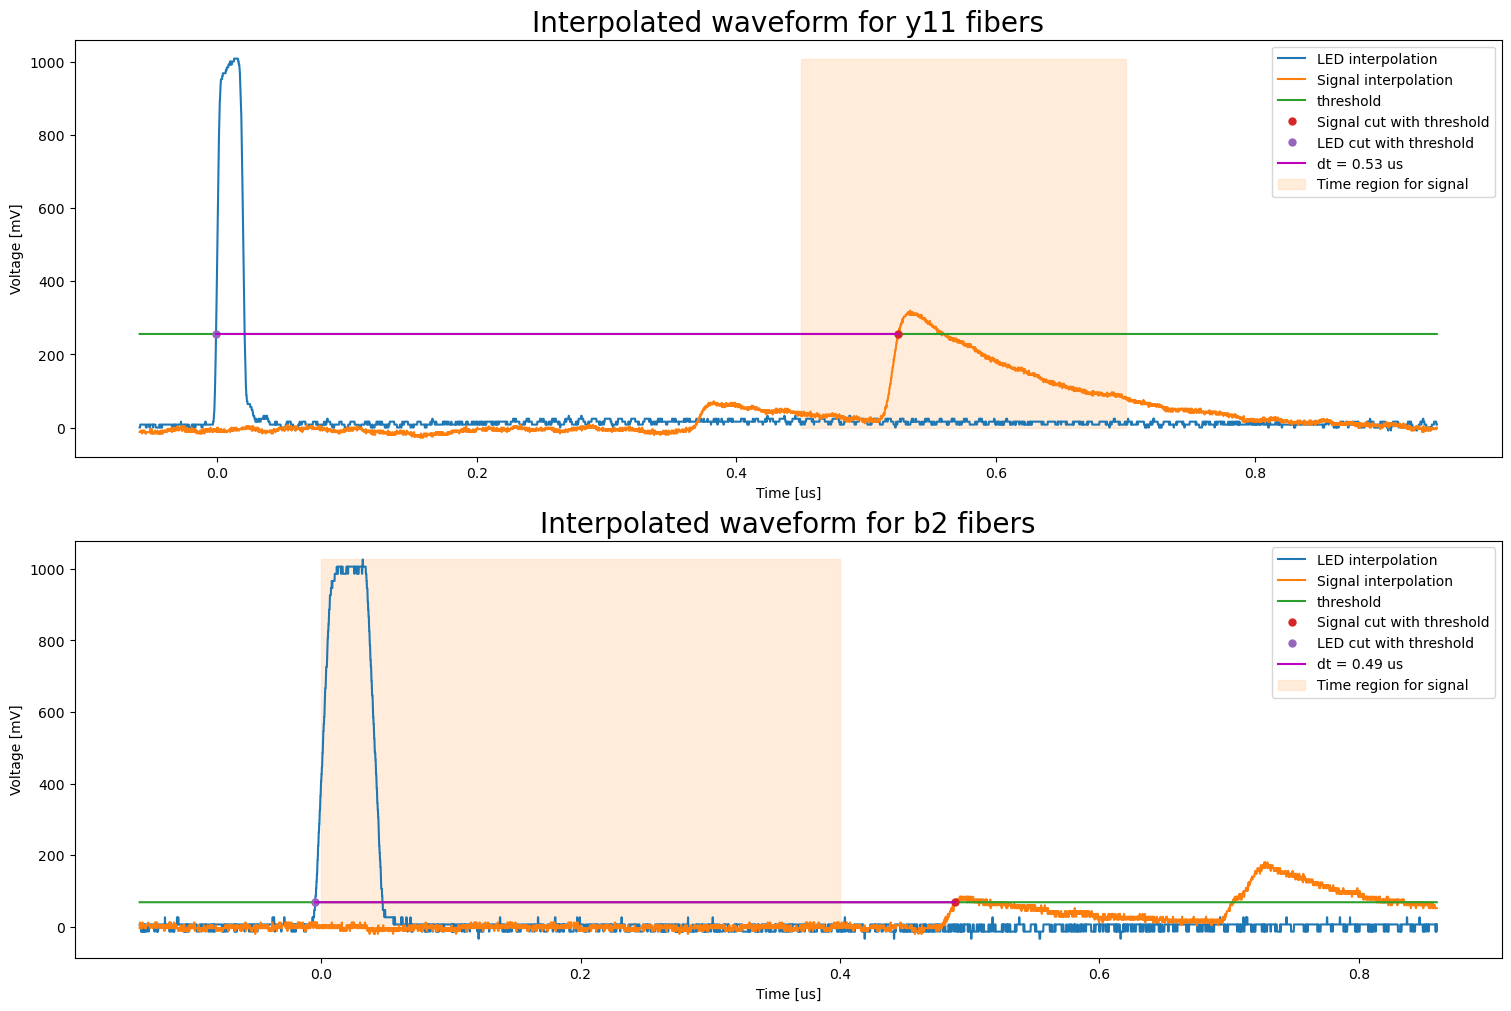

In [38]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10), constrained_layout=True)

for i, key in enumerate(['y11', 'b2']):

    ax[i].plot(tt[key], f_ll[key](tt[key]), label = 'LED interpolation')
    ax[i].plot(tt[key], f_ss[key](tt[key]), label = 'Signal interpolation')
    ax[i].plot(tt[key], th[key]*np.ones(len(tt[key])), label = 'threshold')

    ax[i].fill_between([tt_min[key], tt_max[key]], max(ll[key].max(), ss[key].max()), 
                    color = 'peachpuff', alpha = 0.5, label = r'Time region for signal') 

    ax[i].plot(root_ss[key], th[key], 'o', markersize = 5, label = 'Signal cut with threshold')
    ax[i].plot(root_ll[key], th[key], 'o', markersize = 5, label = 'LED cut with threshold')
    ax[i].plot(np.linspace(root_ss[key], root_ll[key], len(tt[key])), 
               th[key]*np.ones(len(tt[key])), '-m', label = 'dt = %.2f us'%(dt[key]))

    ax[i].set_ylabel('Voltage [mV]');
    ax[i].set_xlabel('Time [us]');
    ax[i].set_title('Interpolated waveform for %s fibers'%(key), size = 20);
    ax[i].legend(loc = 'best')

<h2> Difference in time calculation for all frames </h2>

- <p style="font-size: 17px; color: black;"> Note how we're working with the fact that the signal appears in a certain time region to constrain the valid region of signal we use using the mask.

In [39]:
f_ss = {}
f_ll = {}

root_ss = {}
root_ll = {}

dt = {'y11':[], 'b2':[]}

s_peak = {'y11':[], 'b2':[]}


for key in ['y11', 'b2']:
    print('\n%s fibers_______________________________________'%(key))
    try:
        for frame in range(n_frames):
            
            file_name = files[key][frame]

            tt, ss, ll = wave_prep(file_name, fiber = key, waveform_saturation = np.inf)

            
            tt_region_mask = (tt > tt_min[key]) & (tt < tt_max[key]) # Where to look for the signal

            th = max(0.8*signal_pe[key][0], min(0.8*ss[tt_region_mask].max(), 0.8*ll.max()))

            if fix_th:
                th = th_fixed

            if ss[tt_region_mask].max() < th: 
                print('NO SIGNAL HERE! frame = %s; th = %.2f # [mV]'%(frame, th))
                continue

            if ss[tt_region_mask][0] > th: 
                print('This is not signal, it is the tail of a noise pulse! frame = %s; th = %.2f # [mV]'%(frame, th))
                continue

            # Define the interpolation functions
            f_ss = interp1d(tt, ss) 
            f_ll = interp1d(tt, ll)

            # Define the intervals where to search for roots
            t0 = tt[ss - th < 0.][0]
            tf_ss = tt[(tt > tt_min[key]) & (ss - th > 0.)][0]
            tf_ll = tt[ll - th > 0.][0]

            # Find the roots of the new function for val = th
            root_ss = root_scalar(f_cut, args=(f_ss, th,), bracket=[t0, tf_ss]).root
            root_ll = root_scalar(f_cut, args=(f_ll, th,), bracket=[tt.min(), tf_ll]).root

            s_peak[key].append(ss.max())
            dt[key].append(np.fabs(root_ss - root_ll))

    except Exception as e:
        print("Python sais:", str(e))
        print("Marian sais: Error accured for fiber %s in frame %s"%(key, frame))

    dt[key] = np.array(dt[key])
    s_peak[key] = np.array(s_peak[key])
    


y11 fibers_______________________________________
NO SIGNAL HERE! frame = 1; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 2; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 12; th = 55.51 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 27; th = 326.10 # [mV]
NO SIGNAL HERE! frame = 32; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 60; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 61; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 94; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 118; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 125; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 126; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 142; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 158; th = 55.51 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 170; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 176; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 193; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 201; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 254; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 285; th = 55.5

This is not signal, it is the tail of a noise pulse! frame = 5076; th = 109.91 # [mV]
NO SIGNAL HERE! frame = 5119; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5123; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5128; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5143; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5151; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5171; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5205; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5231; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5263; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5311; th = 55.51 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 5331; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5337; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5342; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5355; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5367; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5382; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5386; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 5405; th = 55.51 # [mV]
NO SIGNAL HER

This is not signal, it is the tail of a noise pulse! frame = 9675; th = 56.18 # [mV]
NO SIGNAL HERE! frame = 9761; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 9801; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 9802; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 9814; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 9830; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 9845; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 9848; th = 55.51 # [mV]
NO SIGNAL HERE! frame = 9857; th = 55.51 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 9942; th = 107.30 # [mV]
NO SIGNAL HERE! frame = 9972; th = 55.51 # [mV]

b2 fibers_______________________________________
This is not signal, it is the tail of a noise pulse! frame = 4; th = 134.03 # [mV]
NO SIGNAL HERE! frame = 33; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 43; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 47; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 53; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 64; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 65; th = 6

This is not signal, it is the tail of a noise pulse! frame = 1571; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1581; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1583; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1602; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1618; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1626; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1643; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1660; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1662; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1668; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1674; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1714; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1716; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1719; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1722; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1730; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1749; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1771; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1779; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 1782; th = 68.38 # [mV]
NO 

NO SIGNAL HERE! frame = 3153; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 3156; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 3177; th = 156.74 # [mV]
NO SIGNAL HERE! frame = 3179; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 3195; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 3197; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 3206; th = 131.83 # [mV]
NO SIGNAL HERE! frame = 3211; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 3212; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 3220; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 3225; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 3232; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 3240; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 3255; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 3264; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 3274; th = 156.78 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 3303; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 3306; th 

This is not signal, it is the tail of a noise pulse! frame = 4972; th = 73.32 # [mV]
NO SIGNAL HERE! frame = 4973; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 4987; th = 140.30 # [mV]
NO SIGNAL HERE! frame = 4992; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 4994; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 5010; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 5011; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 5030; th = 69.87 # [mV]
NO SIGNAL HERE! frame = 5031; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 5032; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 5039; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 5054; th = 98.03 # [mV]
NO SIGNAL HERE! frame = 5066; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 5093; th = 140.89 # [mV]
NO SIGNAL HERE! frame = 5101; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 5106; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 5110; th = 68.38 # [m

NO SIGNAL HERE! frame = 6465; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6477; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6478; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6487; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6505; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6519; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6520; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6529; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6536; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 6558; th = 131.62 # [mV]
NO SIGNAL HERE! frame = 6560; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6565; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6575; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6590; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6596; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6599; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6608; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6609; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6612; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 6616; th = 68.38 # [mV]
NO

NO SIGNAL HERE! frame = 7935; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 7951; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 7965; th = 102.22 # [mV]
NO SIGNAL HERE! frame = 7977; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 7986; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 7992; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 7996; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 8010; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 8032; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 8061; th = 88.04 # [mV]
NO SIGNAL HERE! frame = 8065; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 8078; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 8087; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 8092; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 8095; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 8096; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 8098; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 8105; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 8108; th = 68.38 # [mV]
NO SIGNAL HER

NO SIGNAL HERE! frame = 9603; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9604; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9605; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9644; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9654; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9657; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9668; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 9669; th = 131.56 # [mV]
NO SIGNAL HERE! frame = 9671; th = 68.38 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 9680; th = 87.91 # [mV]
NO SIGNAL HERE! frame = 9685; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9695; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9697; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9704; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9711; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9713; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9718; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9732; th = 68.38 # [mV]
NO SIGNAL HERE! frame = 9733; th = 68.38 # [mV]
NO SIGNAL HER

<h2> Peak identification </h2>

In [40]:
mask_pe = {'y11':[], 'b2':[]}

for key in ['y11', 'b2']:
    for i in range(n_pe[key]):
        mask_pe[key].append(np.fabs(s_peak[key] - signal_pe[key][i]) <= dV) # for fixed dV
#         mask_pe[key].append(np.fabs(s_peak[key] - signal_pe[key][i]) <= accept_region[i]) # for fixed number of bins


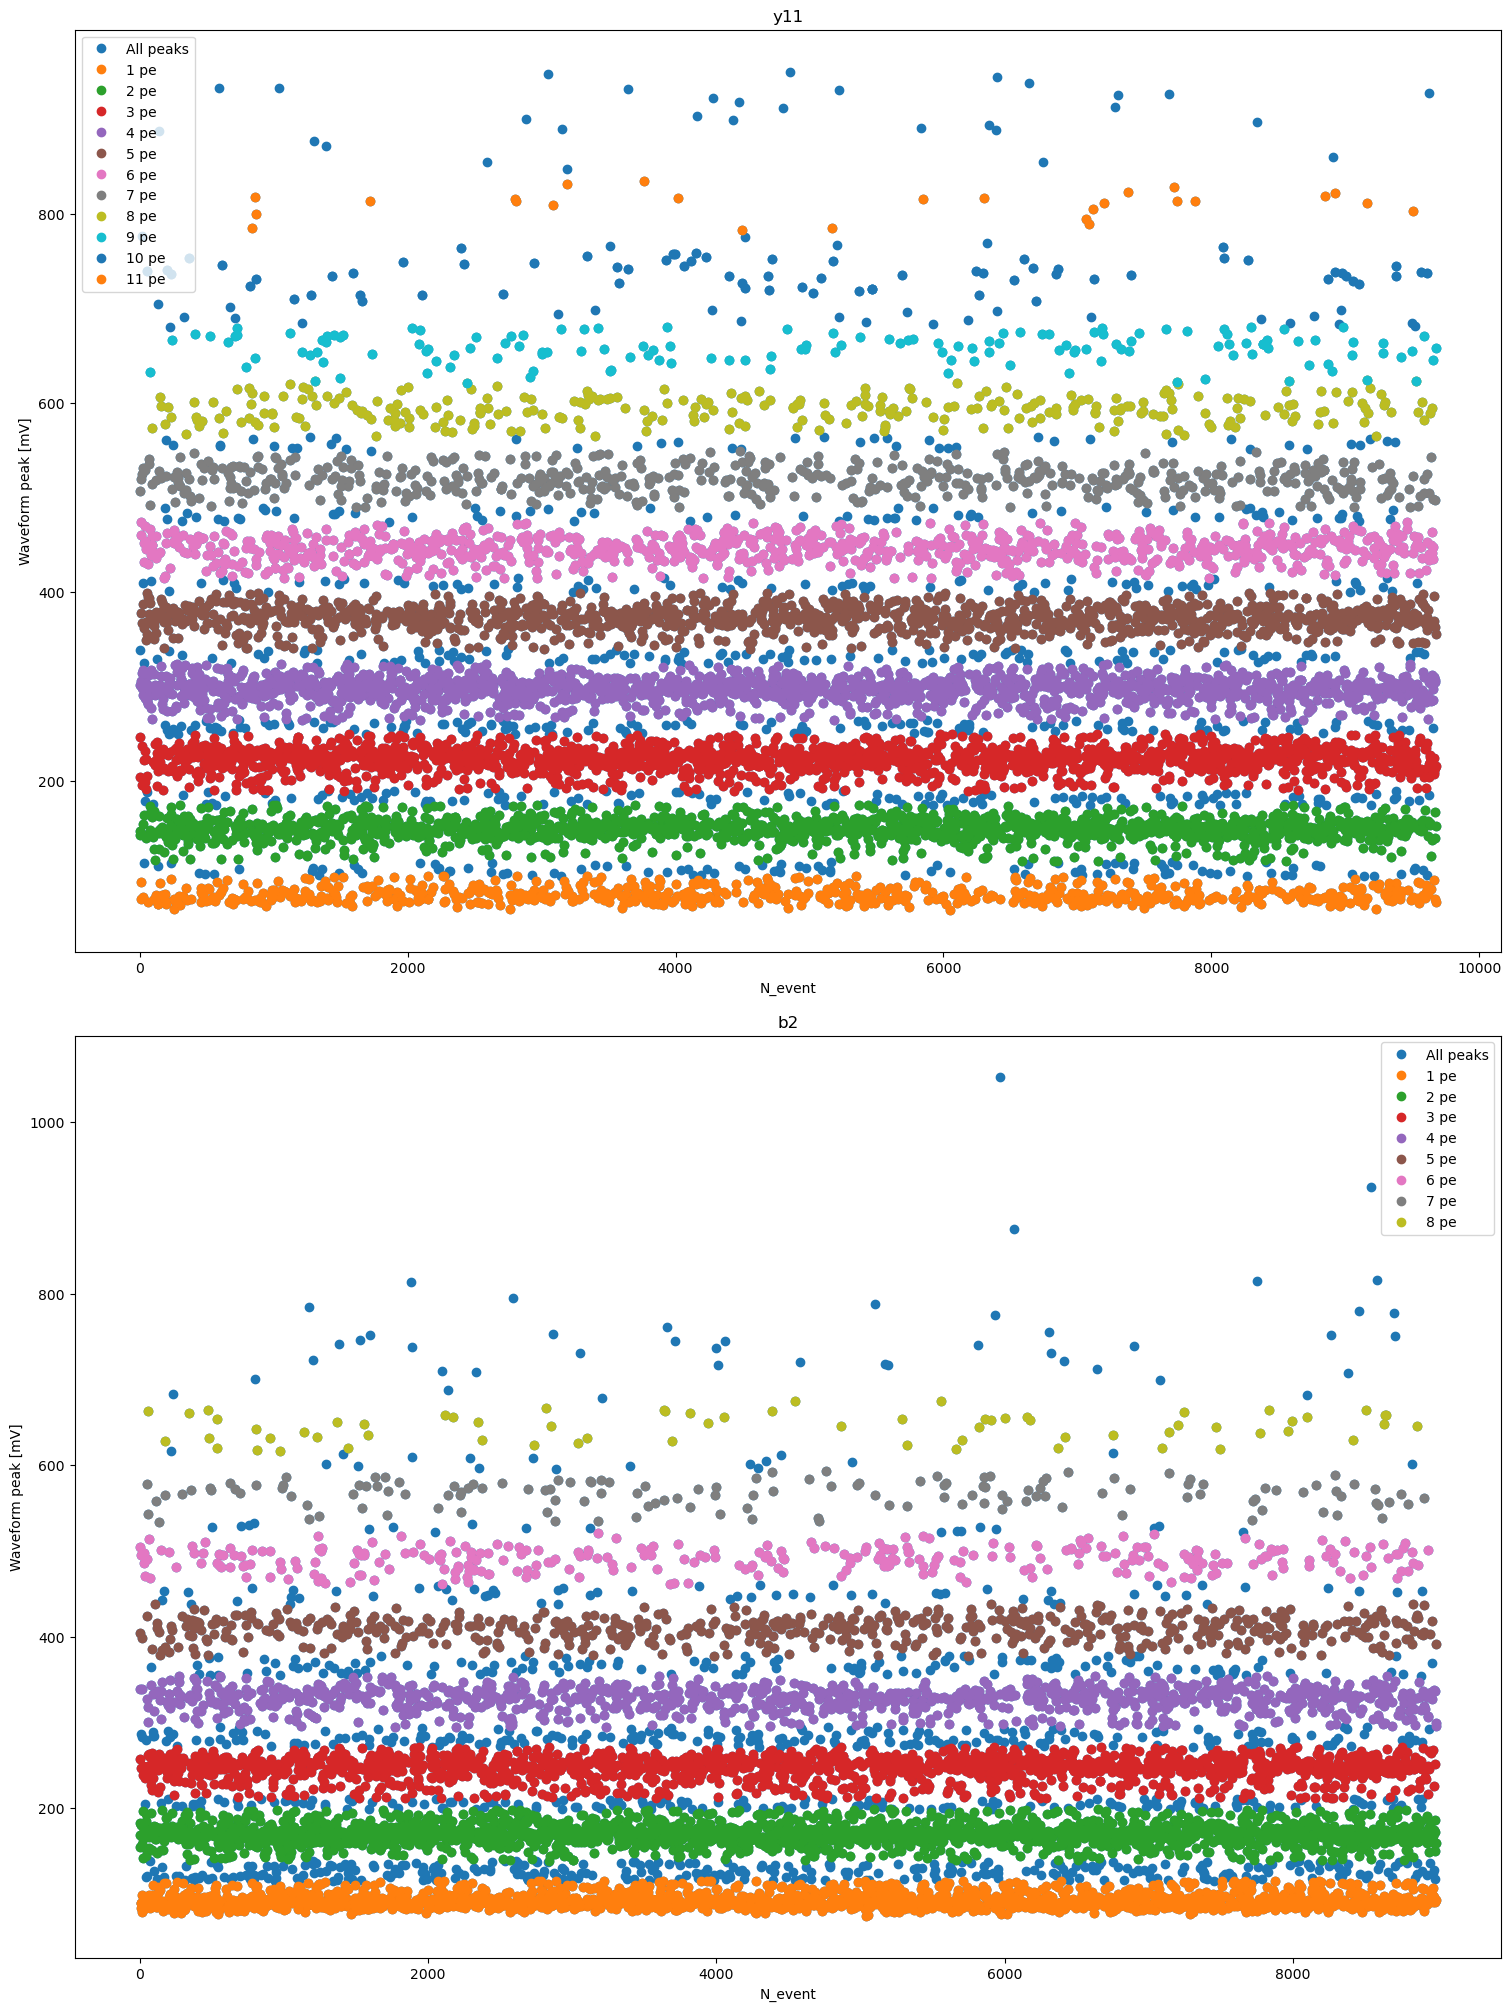

In [41]:
fig, ax = plt.subplots(2, 1, figsize = (15, 20), constrained_layout=True)

for i, key in enumerate(['y11', 'b2']):

    #______________________plot settings________________________________________________________

    x_ax = np.arange(len(s_peak[key]))

    ax[i].plot(x_ax, s_peak[key], 'o', label = 'All peaks')

    for ii in range(len(mask_pe[key])):
        ax[i].plot(x_ax[mask_pe[key][ii]], s_peak[key][mask_pe[key][ii]], 'o', label = '%s pe'%(ii + 1))

    ax[i].set_ylabel('Waveform peak [mV]');
    ax[i].set_xlabel('N_event');
    ax[i].set_title(key);

    # ax[i].set_xlim([0, 20])
    # ax[i].set_ylim([s_peak[key].min(), 150])
    ax[i].legend(loc = 'best')


<h2> Time resolution calculation </h2>

In [42]:
t_res = {}
t_res_err = {}

for key in ['y11', 'b2']:
    
    t_res[key] = np.zeros(n_pe[key])
    t_res_err[key] = np.zeros(n_pe[key])

- <p style="font-size: 17px; color: black;"> Y11 fibers $dt$ distribution.

In [43]:
key = 'y11'

/tmp/ipykernel_115446/2163955253.py:48: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_115446/2163955253.py:48: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_115446/2163955253.py:48: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_115446/2163955253.py:48: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_115446/2163955253.py:48: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_115446/2163955253.py:48: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (

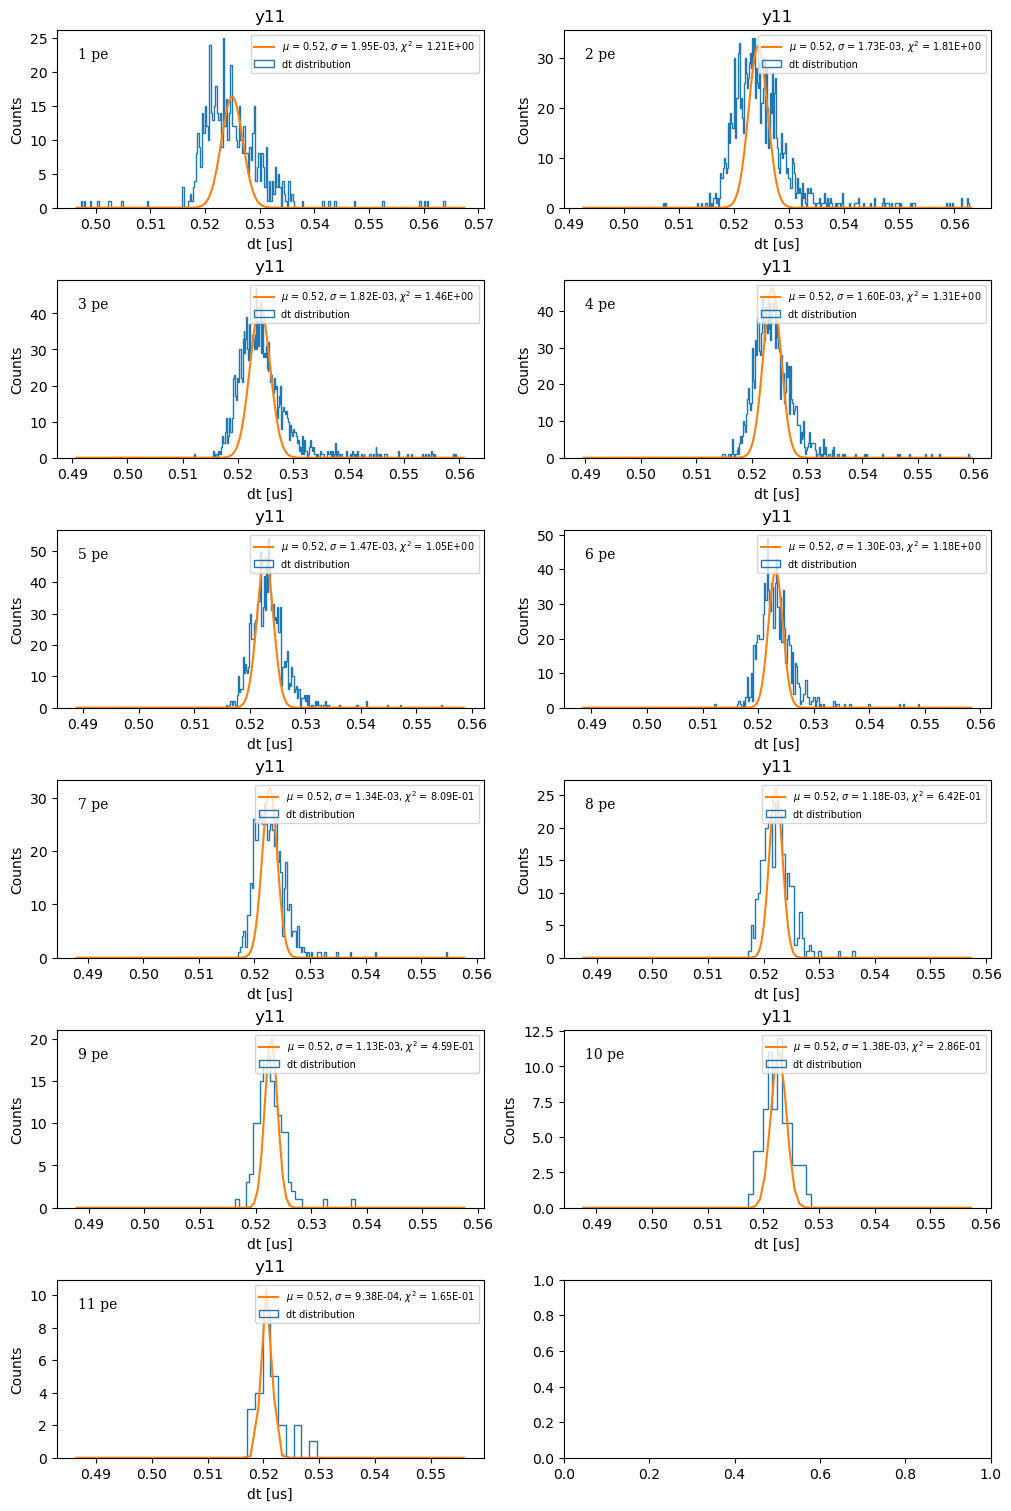

In [44]:
fig, ax = plt.subplots(nrows = math.ceil(n_pe[key]/2.), ncols = 2, figsize=(10,15), constrained_layout=True)

n_row = 0

for pe in range(n_pe[key]):
    
    n_col = pe%2
    
    N_ev = len(dt[key][mask_pe[key][pe]])
    n_bins = int(np.sqrt(N_ev))
    n_bins = 10*int(np.sqrt(N_ev))
#     n_bins = 100

    reg_dif = 15

    region_min = dt[key][mask_pe[key][pe]].mean()*(1 - 1/reg_dif)
    region_max = dt[key][mask_pe[key][pe]].mean()*(1 + 1/reg_dif)
    
    events, bins, bars = ax[n_row, n_col].hist(dt[key][mask_pe[key][pe]], n_bins, 
                                               density=False,
                                               range=(region_min, region_max),
                                               label='dt distribution', 
                                               histtype='step')
    
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)
    y_err = np.sqrt(events)
    
    ev_th = events.sum()*2/100
        
    # gaussian fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
                                          sigma = np.where(y_err > 0., y_err, 1e-3),
                                          p0=[events.sum(), (bins[:-1])[events > ev_th].mean(), 0.001]) 
#                                           bounds=([1,  0.9*bins.mean(), 1e-4], [3., bins.mean(), 1e-2])) 


#     best_fit_line = gauss(x_ax, *popt)
    best_fit_line = gauss(x_ax, *popt)*events.sum()/gauss(x_ax, *popt).sum()
    a, mu, sigma = popt
    
    param_err = np.sqrt(np.diag(pcov))
    a_err, mu_err, sigma_err = param_err
    
    # Calculate p-value and chi-square
    residuals = events - gauss(x_ax, *popt)
    data_err = np.sqrt(events)
    
    chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
    chi2 /= len(bins)
    
    t_res[key][pe] = sigma
    t_res_err[key][pe] = sigma_err

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', 
                          label='$\mu$ = %.2f, $\sigma$ = %.2E, $\chi^{2}$ = %.2E'%(mu, sigma, chi2))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('dt [us]')
    ax[n_row, n_col].set_title(key)

    ax[n_row, n_col].legend(fontsize=7, loc='upper right')
    
    n_row += pe%2
    

- <p style="font-size: 17px; color: black;"> B2 fibers $dt$ distribution.

In [45]:
key = 'b2'

/tmp/ipykernel_115446/3734698718.py:49: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_115446/3734698718.py:49: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_115446/3734698718.py:49: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_115446/3734698718.py:49: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_115446/3734698718.py:49: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_115446/3734698718.py:49: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (

0.056534603439994655 0.16084045872304206
0.04942270736235595 0.14233628880696886
0.04854366943294979 0.12993409722119376
0.061426722069137484 0.11984184304792925
0.06944127976311724 0.11862138926916665
0.0403885753060898 0.10577068085924046
0.06949746679698421 0.10596911734931584
0.07045481438283395 0.09524905016099314


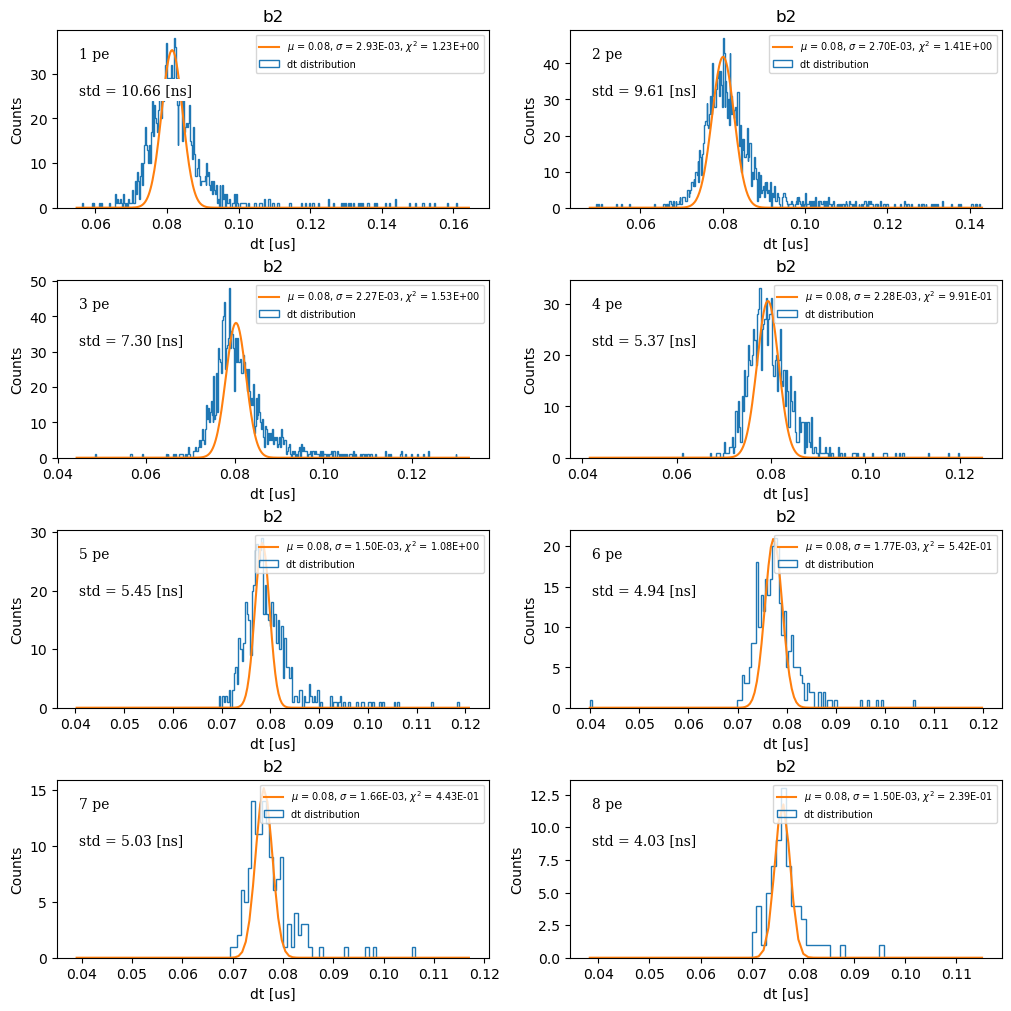

In [66]:
fig, ax = plt.subplots(nrows = math.ceil(n_pe[key]/2.), ncols = 2, figsize=(10,10), constrained_layout=True)

n_row = 0

for pe in range(n_pe[key]):
    
    n_col = pe%2
    
    N_ev = len(dt[key][mask_pe[key][pe]])
    n_bins = int(np.sqrt(N_ev))
    n_bins = 10*int(np.sqrt(N_ev))
#     n_bins = 100


    reg_dif = 2

    region_min = dt[key][mask_pe[key][pe]].mean()*(1 - 1/reg_dif)
    region_max = dt[key][mask_pe[key][pe]].mean()*(1 + 1/reg_dif)
    
    events, bins, bars = ax[n_row, n_col].hist(dt[key][mask_pe[key][pe]], n_bins, 
                                               density=False,
                                               range=(region_min, region_max),
                                               label='dt distribution', 
                                               histtype='step')
    
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)
    y_err = np.sqrt(events)
    
    ev_th = events.sum()*2/100
    
    # gaussian fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
                                          sigma = np.where(y_err > 0., y_err, 1e-3),
                                          p0=[events.sum(), (bins[:-1])[events > ev_th].mean(), 0.001]) 
#                                           bounds=([1,  0.9*bins.mean(), 1e-4], [3., bins.mean(), 1e-2])) 


#     best_fit_line = gauss(x_ax, *popt)
    best_fit_line = gauss(x_ax, *popt)*events.sum()/gauss(x_ax, *popt).sum()
    a, mu, sigma = popt
    
    param_err = np.sqrt(np.diag(pcov))
    a_err, mu_err, sigma_err = param_err
    
    # Calculate p-value and chi-square
    residuals = events - gauss(x_ax, *popt)
    data_err = np.sqrt(events)
    
    chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
    chi2 /= len(bins)
    
    t_res[key][pe] = sigma
    t_res_err[key][pe] = sigma_err

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', 
                          label='$\mu$ = %.2f, $\sigma$ = %.2E, $\chi^{2}$ = %.2E'%(mu, sigma, chi2))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                          fontsize=10, verticalalignment='top', fontfamily='serif',
                          bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
    
    aux = dt[key][(mask_pe[key][pe]) & (dt[key] > region_min) & (dt[key] < region_max)]
    std = aux.std()*1e3
    
    ax[n_row, n_col].text(0.05, .7, 
                          r'std = %.2f [ns]'%(std), 
                          transform=ax[n_row, n_col].transAxes,
                          fontsize=10, verticalalignment='top', fontfamily='serif',
                          bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))


    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('dt [us]')
    ax[n_row, n_col].set_title(key)

    ax[n_row, n_col].legend(fontsize=7, loc='upper right')
    
    n_row += pe%2
    

- <p style="font-size: 17px; color: black;"> Time resolution vs $N_{pe}$.

In [47]:
colors = {'y11':'g', 'b2':'b'}

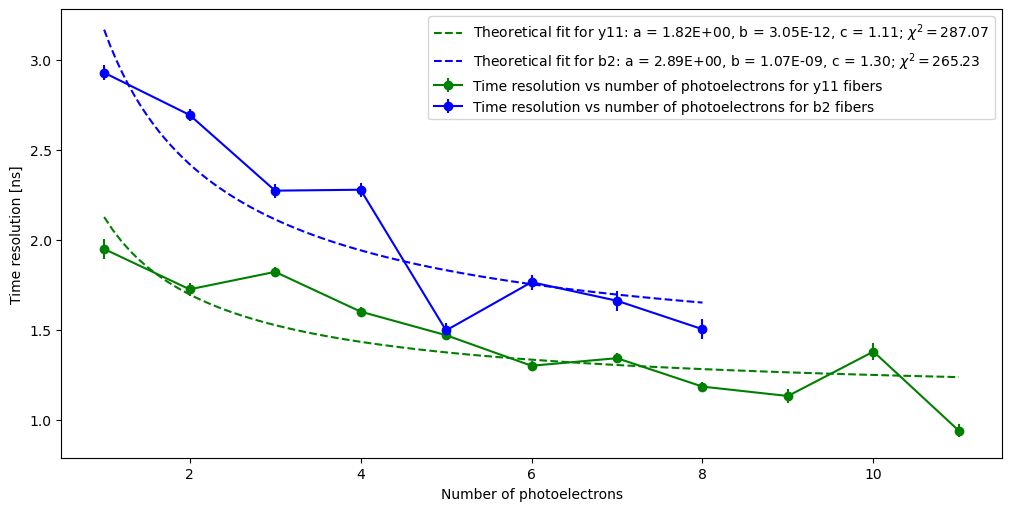

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

for key in ['y11', 'b2']:
    
    x_ax = np.arange(len(t_res[key])) + 1

    ax.errorbar(x_ax, t_res[key]*1e3, 
#                 yerr = 0., 
                yerr = t_res_err[key]*1e3, 
                fmt = '-o', color = colors[key], 
                label = 'Time resolution vs number of photoelectrons for %s fibers'%(key))

    ax.set_ylabel('Time resolution [ns]')
    ax.set_xlabel('Number of photoelectrons')


    # Resolution fit
    #     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 20.]) 
    popt, pcov = scipy.optimize.curve_fit(resolution_eq, x_ax, t_res[key]*1e3, 
                                          bounds=([0., 0., 0.], [np.inf, np.inf, np.inf])) 

    aa, bb, cc = popt


    # Calculate the residuals and chi-square
    residuals = t_res[key]*1e3 - resolution_eq(x_ax, *popt)
    data_err = t_res_err[key]*1e3

    chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))


    x_ax_fit = np.linspace(x_ax.min(), x_ax.max(), 100)
    best_fit_line = resolution_eq(x_ax_fit, aa, bb, cc)

    ax.plot(x_ax_fit, best_fit_line, '--', color = colors[key], 
            label='Theoretical fit for %s: a = %.2E, b = %.2E, c = %.2f; $\chi^{2} = %.2f$'%(key, aa, bb, cc, chi2))

    ax.legend(loc = 'best')
    

In [56]:
dt[key][mask_pe[key][pe]].std()
std[key]

array([76.14354914, 55.03800998, 38.11160884, 27.35577127, 13.1915336 ,
       22.90525363,  8.34848136,  4.02904882])

/tmp/ipykernel_115446/3051998888.py:52: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))
/tmp/ipykernel_115446/3051998888.py:52: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))


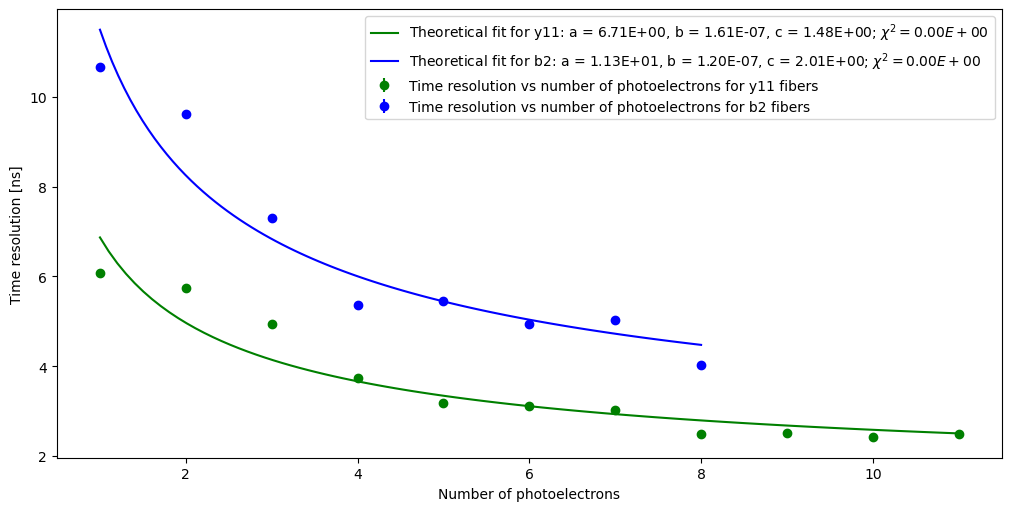

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

std = {}
std_err = {}

reg_dif = {'y11': 15, 'b2':2}

for key in ['y11', 'b2']:
    
    std[key] = np.zeros(n_pe[key])
    std_err[key] = np.zeros(n_pe[key])
    

for key in ['y11', 'b2']:

    for pe in range(n_pe[key]):
        
        region_min = dt[key][mask_pe[key][pe]].mean()*(1 - 1/reg_dif[key])
        region_max = dt[key][mask_pe[key][pe]].mean()*(1 + 1/reg_dif[key])
    
        masked_dt = dt[key][(mask_pe[key][pe]) & (dt[key] > region_min) & (dt[key] < region_max)]
        std[key][pe] = masked_dt.std()*1e3 # [ns]

    

    #_________plot_settings_________________________________________________

    x_ax = np.arange(len(t_res[key])) + 1

    ax.errorbar(x_ax, std[key], 
                yerr = 0., 
#                 yerr = std_err[key], 
                fmt = 'o', color = colors[key], 
                label = 'Time resolution vs number of photoelectrons for %s fibers'%(key))

    ax.set_ylabel('Time resolution [ns]')
    ax.set_xlabel('Number of photoelectrons')


    # Resolution fit
    #     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 20.]) 
    popt, pcov = scipy.optimize.curve_fit(resolution_eq, x_ax, std[key], 
                                          bounds=([0., 0., 0.], [np.inf, np.inf, np.inf])) 

    aa, bb, cc = popt


    # Calculate the residuals and chi-square
    residuals = std[key]*1e3 - resolution_eq(x_ax, *popt)
    data_err = std_err[key]*1e3

    chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))


    x_ax_fit = np.linspace(x_ax.min(), x_ax.max(), 100)
    best_fit_line = resolution_eq(x_ax_fit, aa, bb, cc)

    ax.plot(x_ax_fit, best_fit_line, '-', color = colors[key], 
            label='Theoretical fit for %s: a = %.2E, b = %.2E, c = %.2E; $\chi^{2} = %.2E$'%(key, aa, bb, cc, chi2))

    ax.legend(loc = 'best')
    

<p style="font-size: 17px; color: black;"> Energy resolution calculation

In [47]:
key = 'y11'

676.0 676.0000000000002 676.0000000000001
1596.0 1596.0000000000005 1596.0000000000002
1819.0 1819.0 1819.0000000000002
1620.0 1620.0000000000002 1620.0000000000002
1272.0 1272.0 1272.0000000000002
894.0 894.0000000000001 894.0000000000001
547.0 547.0000000000001 547.0000000000001
285.0 285.00000000000006 285.00000000000006
143.0 143.0 143.00000000000003
68.0 68.00000000000003 68.00000000000001
26.0 26.000000000000004 26.000000000000004


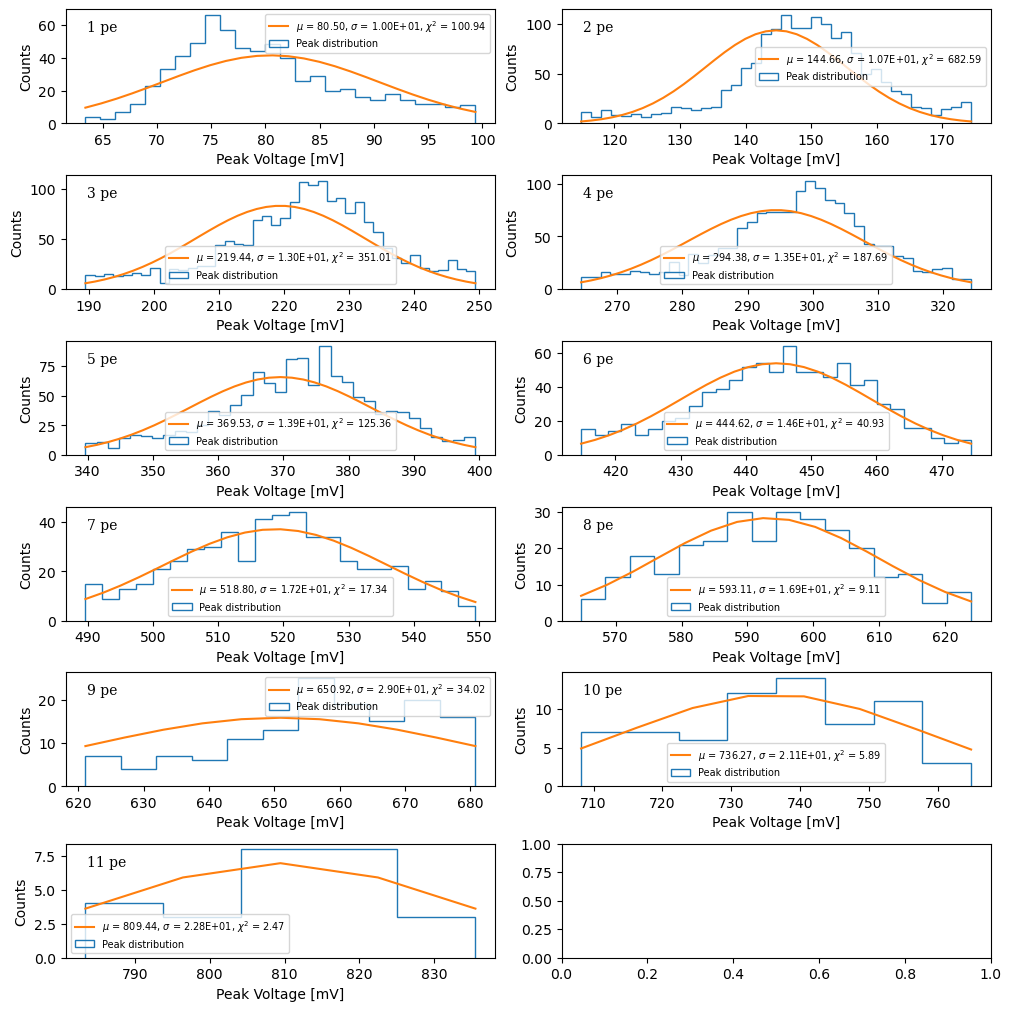

In [48]:
fig, ax = plt.subplots(nrows=int(np.ceil(n_pe[key]/2)), ncols=2, figsize=(10,10), constrained_layout=True)

n_row = 0

e_res = np.zeros(n_pe[key])
e_res_err = np.zeros(n_pe[key])

for pe in range(n_pe[key]):
    
    n_col = pe%2
    
    N_ev = len(s_peak[key][mask_pe[key][pe]])
#     n_bins = 5*int(np.sqrt(N_ev))
    n_bins = int(np.sqrt(N_ev))
    
    events, bins, bars = ax[n_row, n_col].hist(s_peak[key][mask_pe[key][pe]], n_bins, 
                                     density=False, 
#                                                range=(0.08, 0.15),
                                     label='Peak distribution', 
                                     histtype='step')
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

#     # gaussian fit
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 20.]) 
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
                                          sigma = np.where(events > 0., np.sqrt(events), 1e-3),
                                          bounds=([events.sum(),  0.9*bins.mean(), 10.], [np.inf, bins.mean(), 60.])) 
    
    best_fit_line = gauss(x_ax, *popt)
    a, mu, sigma = popt
    
    print(events.sum(), best_fit_line.sum(), a)
    
    param_err = np.sqrt(np.diag(pcov))
    a_err, mu_err, sigma_err = param_err
    
#     # Calculate the residuals and chi-square
#     residuals = events - gauss(x_ax, *popt)
#     data_err = np.sqrt(events)
    
#     chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))
    
    # Calculate p-value and chi-square
    fit_norm = best_fit_line*events.sum()/best_fit_line.sum() # need to normalize the fit 
    chi2, p_value = stats.chisquare(f_obs = events, f_exp = fit_norm, axis = None)
#     chi2, p_value = stats.chisquare(f_obs = events, f_exp = best_fit_line, axis = None)
    
    e_res[pe] = 100*sigma/mu
    e_res_err[pe] = 100*np.sqrt( (sigma_err/mu)**2 + (sigma*mu_err/mu**2)**2 )

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, best_fit_line, '-', 
                          label='$\mu$ = %.2f, $\sigma$ = %.2E, $\chi^{2}$ = %.2f'%(mu, sigma, chi2))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('Peak Voltage [mV]')

    ax[n_row, n_col].legend(fontsize=7, loc='best')
    
    n_row += pe%2
    

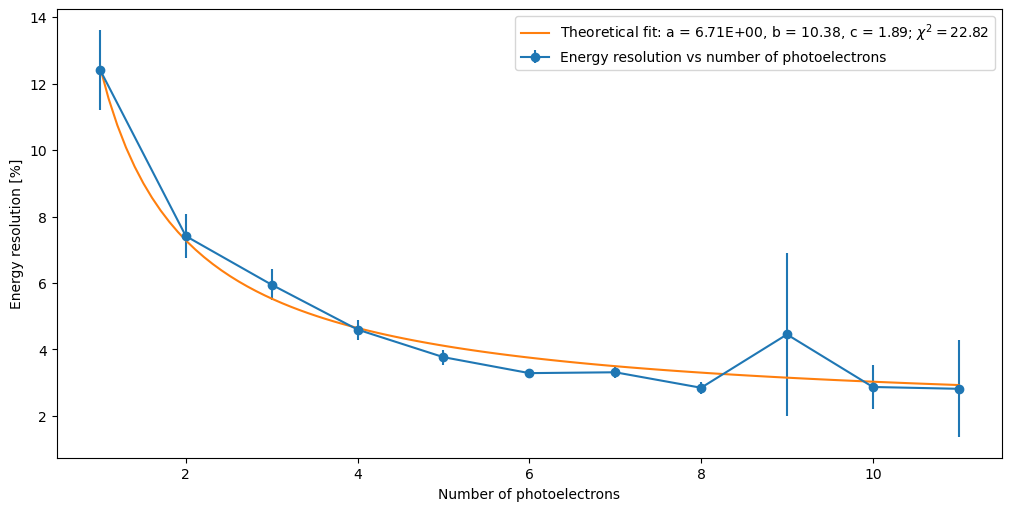

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

x_ax = np.arange(len(e_res)) + 1


ax.errorbar(x_ax, e_res, yerr = e_res_err, fmt = '-o', label = 'Energy resolution vs number of photoelectrons')

ax.set_ylabel('Energy resolution [%]')
ax.set_xlabel('Number of photoelectrons')



# Resolution fit
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 20.]) 
popt, pcov = scipy.optimize.curve_fit(resolution_eq, x_ax, e_res, 
                                      bounds=([0., 0., 0.], [np.inf, np.inf, np.inf])) 

aa, bb, cc = popt


# Calculate the residuals and chi-square
residuals = e_res - resolution_eq(x_ax, *popt)
data_err = e_res_err

chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))


x_ax_fit = np.linspace(x_ax.min(), x_ax.max(), 100)
best_fit_line = resolution_eq(x_ax_fit, aa, bb, cc)

ax.plot(x_ax_fit, best_fit_line, '-', 
        label='Theoretical fit: a = %.2E, b = %.2f, c = %.2f; $\chi^{2} = %.2f$'%(aa, bb, cc, chi2))

    
ax.legend(loc = 'best')